In [529]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

from models.CNN_model import CNN
from models.CNN_SE_model import CNN_SE

In [530]:
OUTPUT_BASE = "interpretability-images"

MODEL_CNN_PATH = "saved-models/cnn.pt"
MODEL_CNN_SE_PATH = "saved-models/cnn-se.pt"

cnn: CNN = torch.load(MODEL_CNN_PATH).cpu()
cnn_se: CNN_SE = torch.load(MODEL_CNN_SE_PATH).cpu()

data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [531]:
def get_convolutions(module: torch.nn.Module) -> list[torch.nn.Conv2d]:
    convolution_layers = []
    for module_layer in module.children():
        if type(module_layer) == torch.nn.Conv2d:
            convolution_layers.append(module_layer)

    return convolution_layers


In [532]:
def view_kernels(module: torch.nn.Module, layer: int = 0, ch: int = 0, view_all_channels: bool = False):
    output_dir = f"{module._get_name()}-layer{layer}"
    if not OUTPUT_BASE in os.listdir():
        os.mkdir(OUTPUT_BASE)

    if not output_dir in os.listdir(OUTPUT_BASE):
        os.mkdir(f"{OUTPUT_BASE}/{output_dir}")

    convolution_layers = get_convolutions(module)
    kernels = convolution_layers[layer].weight.detach().clone()

    out_channels, in_channels, *ksize = kernels.shape
    print(f"Out Channels: {out_channels}, In Channels: {in_channels}, Kernel Size: {ksize}")

    if view_all_channels:
        kernels = kernels.view(out_channels * in_channels, -1, ksize[0], ksize[1])
    else:
        #[out_channels, in_channels, kernel_width, kernel_height]
        kernels = kernels[:, ch, :, :].unsqueeze(dim=1)

    imgs = torchvision.utils.make_grid(kernels, padding=1, nrow=12, normalize=True)
    imgs = imgs.permute(1,2,0)

    fig_height, fig_width, fig_channels = imgs.shape
    print(f"Figure Height: {fig_height}, Figure Width: {fig_width}, Figure Channels: {fig_channels}")

    plt.figure(figsize=(12,(out_channels * in_channels) / 12))
    plt.axis("off")
    image = plt.imshow(imgs)
    plt.title(f"{module._get_name()}, Channel: {ch if not view_all_channels else 'All'}, Layer: {layer}")
    plt.show()

    plt.imsave(f"{OUTPUT_BASE}/{output_dir}/kernels-channel-{ch}.png", image.get_array())

In [533]:
def view_feature_map(module: torch.nn.Module, image_path: str, layer: int = 0):
    output_dir = f"{module._get_name()}-layer{layer}"
    if not OUTPUT_BASE in os.listdir():
        os.mkdir(OUTPUT_BASE)

    if not output_dir in os.listdir(OUTPUT_BASE):
        os.mkdir(f"{OUTPUT_BASE}/{output_dir}")

    convolution_layers = get_convolutions(module)
    print(f"Number of convolution layers in {module._get_name()}: {len(convolution_layers)}")

    image = Image.open(image_path)
    assert image.size == (224, 224)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Original Image")
    ax1.axis("off")

    image = data_transforms(image)

    ax2.imshow(image.permute(1,2,0))
    ax2.set_title("Image After Transforms")
    ax2.axis("off")
    plt.show()
    fig.savefig(f"{OUTPUT_BASE}/{output_dir}/{image_path.split('/')[-1]}-layer-{layer}-transforms.png")

    feature_maps = []
    for conv_layer in convolution_layers:
        image = conv_layer(image)
        feature_maps.append(image.detach())

    imgs = torchvision.utils.make_grid(feature_maps[layer].unsqueeze(1), padding=1, normalize=True)

    fig = plt.figure()
    plt.axis("off")
    plt.title(f"Feature Maps for Convolution Layer:\n{convolution_layers[layer]}")
    plt.imshow(imgs.permute(1,2,0))
    plt.show()
    fig.savefig(f"{OUTPUT_BASE}/{output_dir}/{image_path.split('/')[-1]}-layer-{layer}-featuremaps.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN: 3


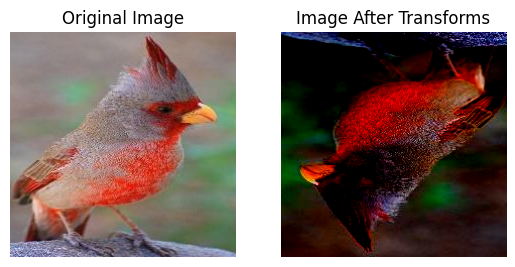

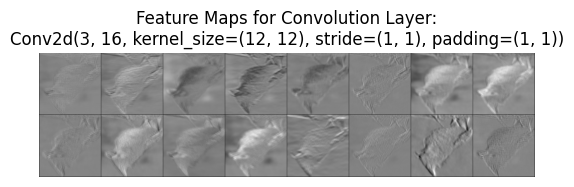

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN: 3


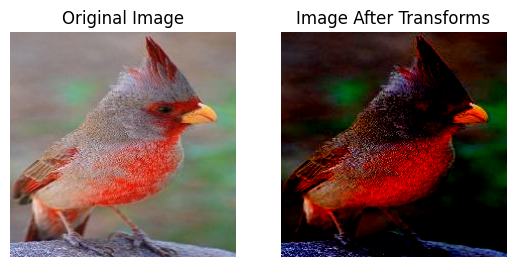

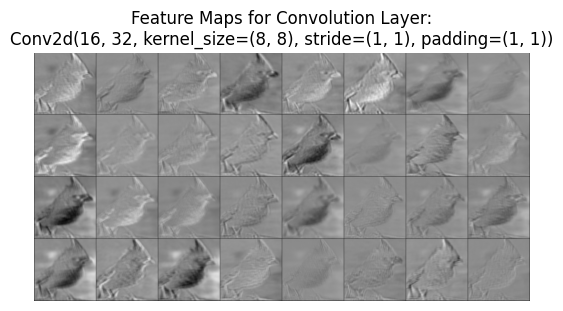

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN: 3


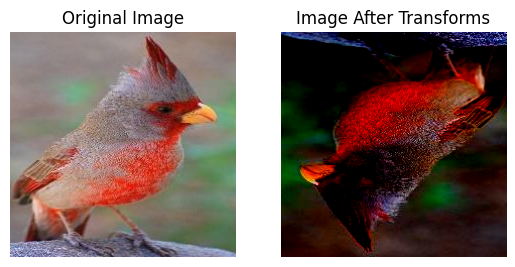

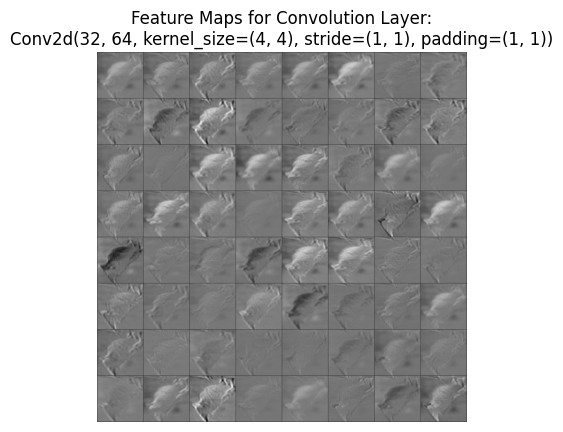

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN: 3


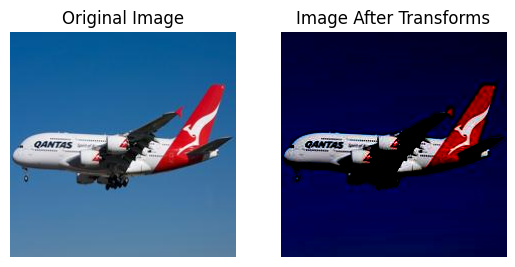

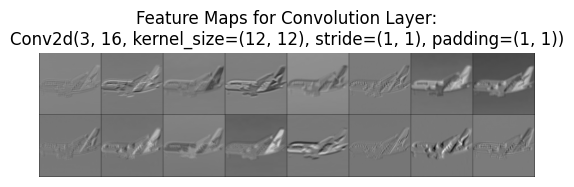

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN: 3


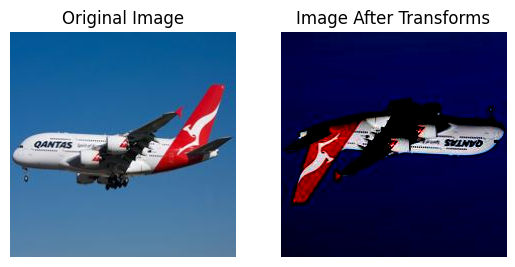

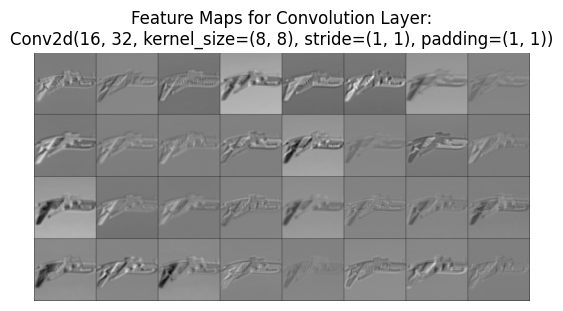

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN: 3


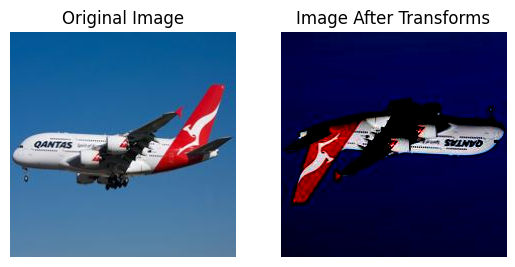

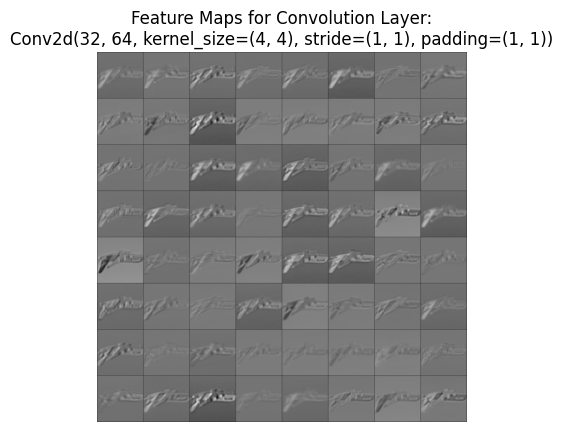

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN_SE: 3


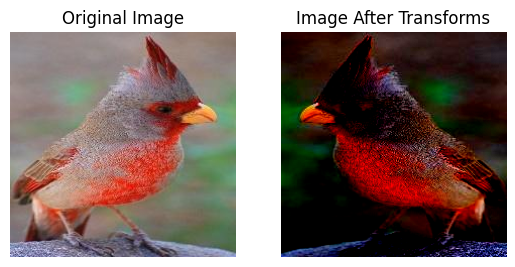

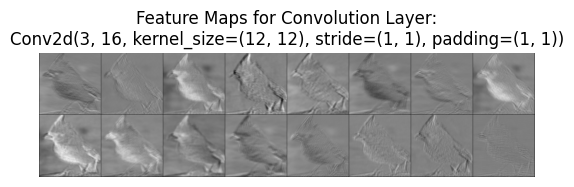

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN_SE: 3


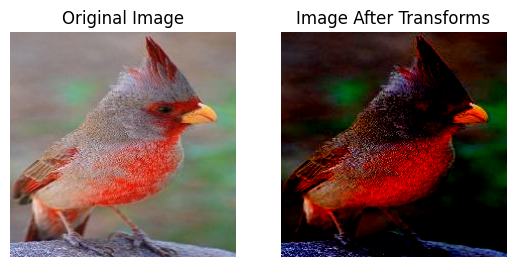

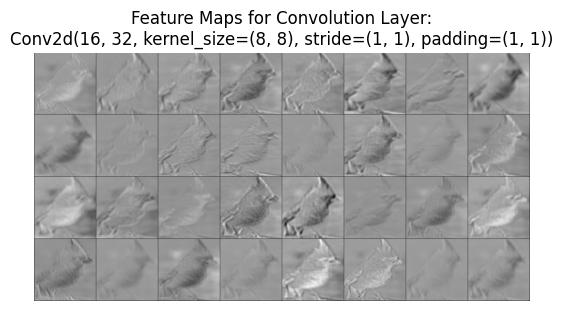

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN_SE: 3


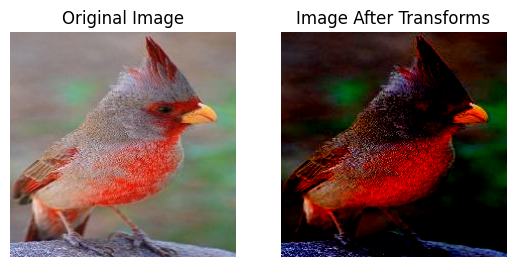

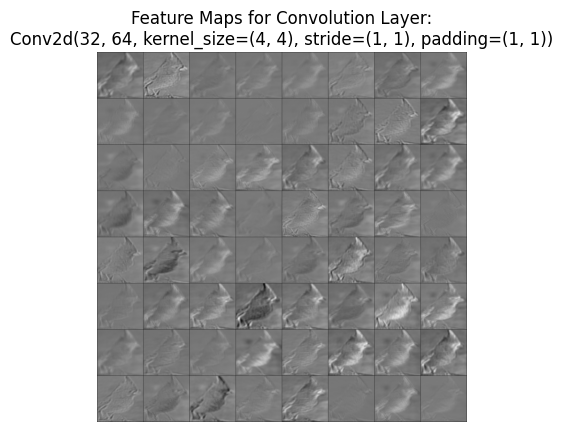

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN_SE: 3


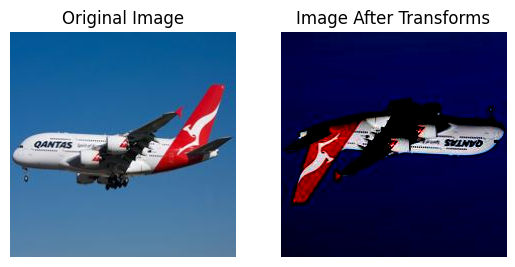

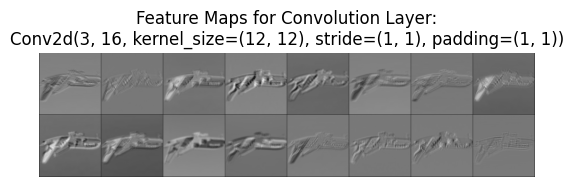

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN_SE: 3


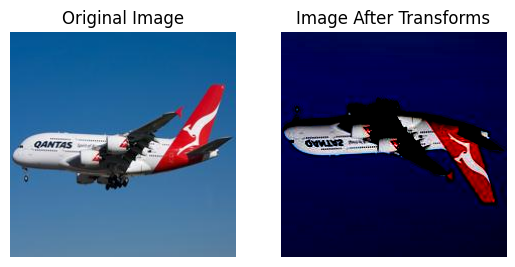

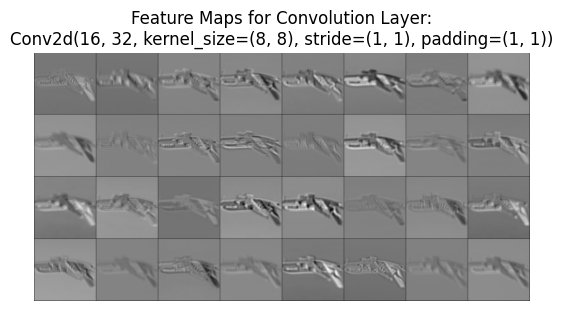

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of convolution layers in CNN_SE: 3


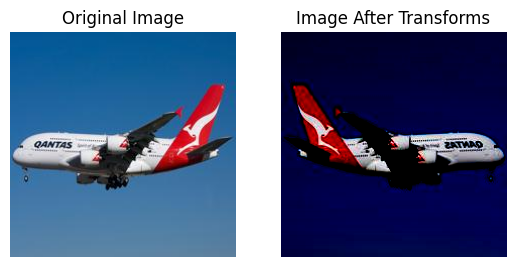

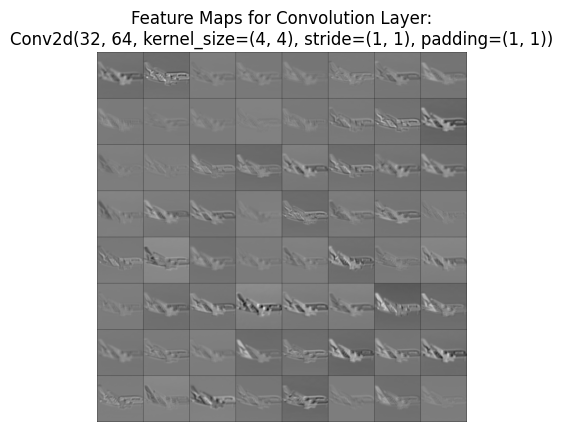

In [534]:
view_feature_map(cnn, "preprocessed-data/images/Cardinalis Sinuatus/11405.jpg", layer=0)
view_feature_map(cnn, "preprocessed-data/images/Cardinalis Sinuatus/11405.jpg", layer=1)
view_feature_map(cnn, "preprocessed-data/images/Cardinalis Sinuatus/11405.jpg", layer=2)

view_feature_map(cnn, "preprocessed-data/images/A380/00840.jpg", layer=0)
view_feature_map(cnn, "preprocessed-data/images/A380/00840.jpg", layer=1)
view_feature_map(cnn, "preprocessed-data/images/A380/00840.jpg", layer=2)

view_feature_map(cnn_se, "preprocessed-data/images/Cardinalis Sinuatus/11405.jpg", layer=0)
view_feature_map(cnn_se, "preprocessed-data/images/Cardinalis Sinuatus/11405.jpg", layer=1)
view_feature_map(cnn_se, "preprocessed-data/images/Cardinalis Sinuatus/11405.jpg", layer=2)

view_feature_map(cnn_se, "preprocessed-data/images/A380/00840.jpg", layer=0)
view_feature_map(cnn_se, "preprocessed-data/images/A380/00840.jpg", layer=1)
view_feature_map(cnn_se, "preprocessed-data/images/A380/00840.jpg", layer=2)

Out Channels: 16, In Channels: 3, Kernel Size: [12, 12]
Figure Height: 27, Figure Width: 157, Figure Channels: 3
Out Channels: 32, In Channels: 16, Kernel Size: [8, 8]
Figure Height: 28, Figure Width: 109, Figure Channels: 3
Out Channels: 64, In Channels: 32, Kernel Size: [4, 4]
Figure Height: 31, Figure Width: 61, Figure Channels: 3
Out Channels: 16, In Channels: 3, Kernel Size: [12, 12]
Figure Height: 27, Figure Width: 157, Figure Channels: 3
Out Channels: 32, In Channels: 16, Kernel Size: [8, 8]
Figure Height: 28, Figure Width: 109, Figure Channels: 3
Out Channels: 64, In Channels: 32, Kernel Size: [4, 4]
Figure Height: 31, Figure Width: 61, Figure Channels: 3


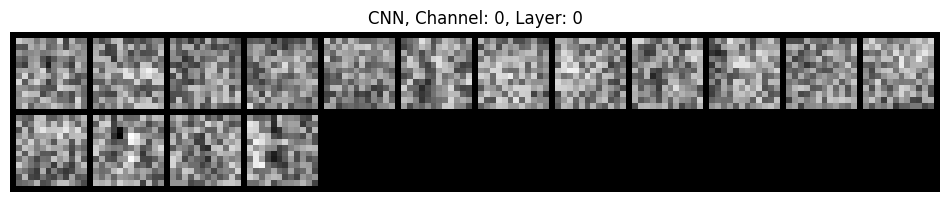

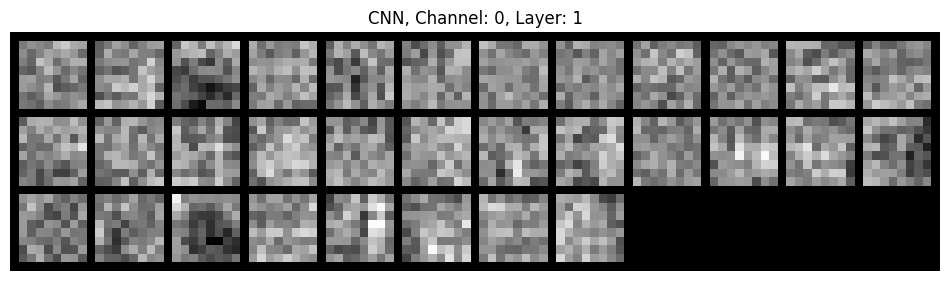

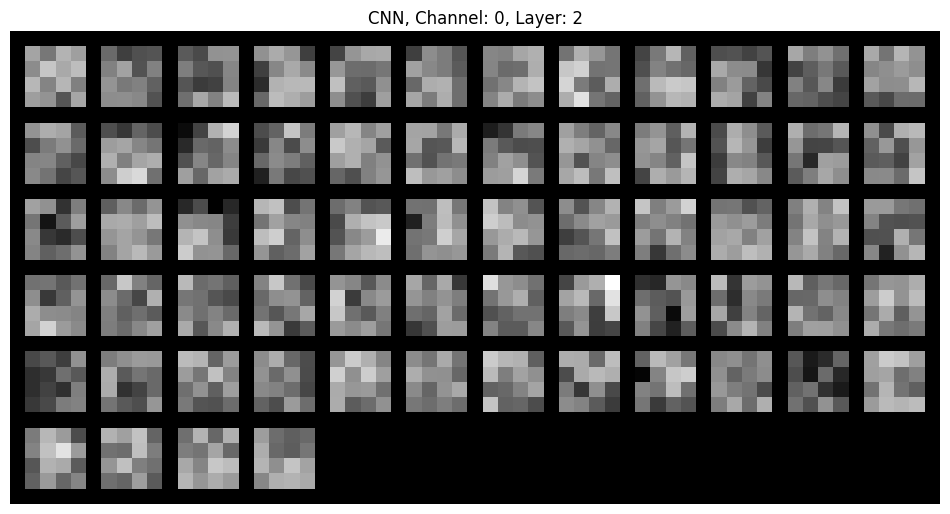

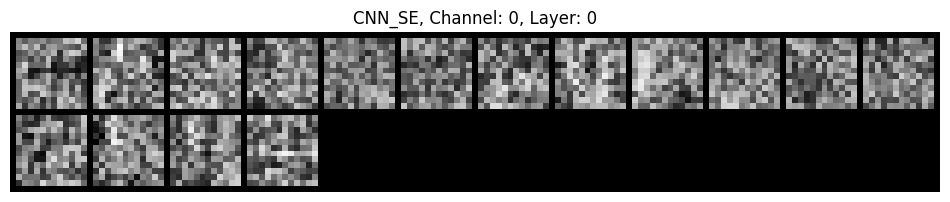

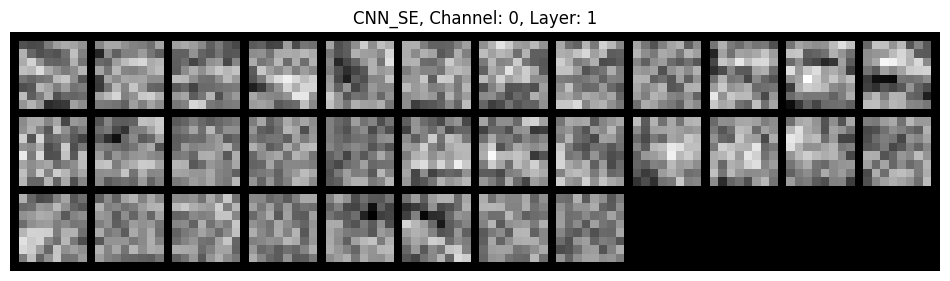

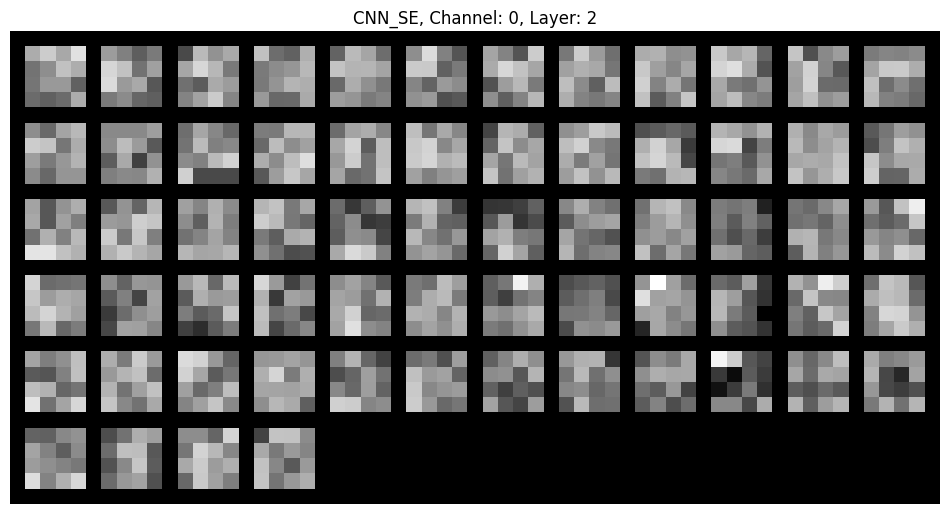

In [535]:
view_kernels(cnn, layer=0)
view_kernels(cnn, layer=1)
view_kernels(cnn, layer=2)

view_kernels(cnn_se, layer=0)
view_kernels(cnn_se, layer=1)
view_kernels(cnn_se, layer=2)